# Necessary libraries

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
from __future__ import print_function
import numpy as np
import splitfolders
import os, shutil
import seaborn as sns
import matplotlib.pyplot as plt  
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, regularizers, layers, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pathlib 

# Set parameters for plots
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print ("TensorFlow version: " + tf.__version__)
print ("Keras version:" + keras.__version__)

TensorFlow version: 2.8.2
Keras version:2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualization

In [ ]:
IMG_DIR = '/content/drive/MyDrive/alzheimer'
IMG_DIR = pathlib.Path(IMG_DIR)
class_names = np.array([sorted(item.name for item in IMG_DIR.glob("*"))])
class_names

array([['Mild_Demented', 'Moderate_Demented', 'Non_Demented',
        'Very_Mild_Demented']], dtype='<U18')

In [ ]:
def visualize(direction):
    list_dir=os.listdir(direction)
    plt.figure(figsize=(14,8))
    print(str(direction)[33:])
    for i in range(1,4):
        plt.subplot(2,3,i)
        img= plt.imread(os.path.join(direction,list_dir[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

Non_Demented


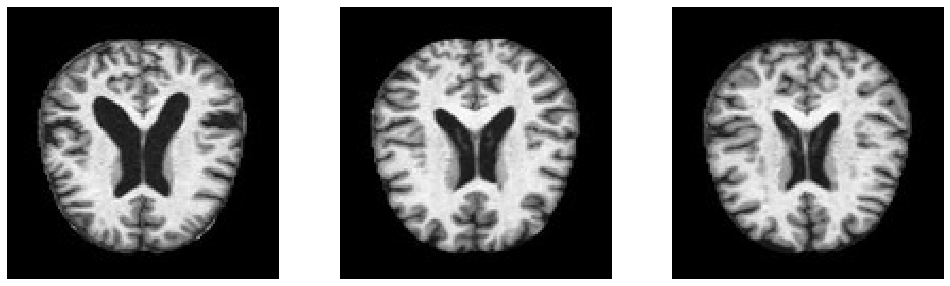

In [ ]:
NonDemented_dir= '/content/drive/MyDrive/alzheimer/Non_Demented'
visualize(NonDemented_dir)

Very_Mild_Demented


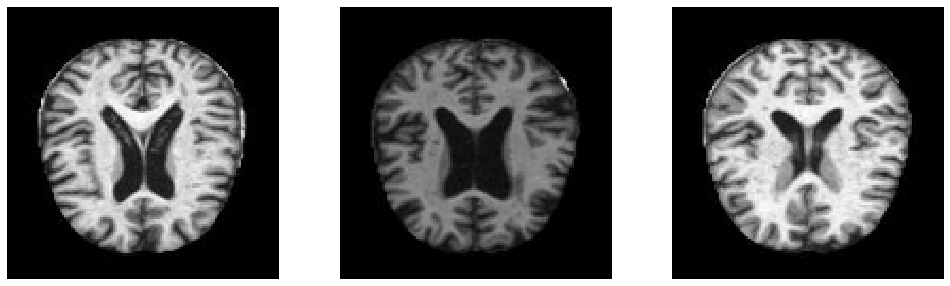

In [ ]:
VeryMildDemented_dir= '/content/drive/MyDrive/alzheimer/Very_Mild_Demented'
visualize(VeryMildDemented_dir)

Mild_Demented


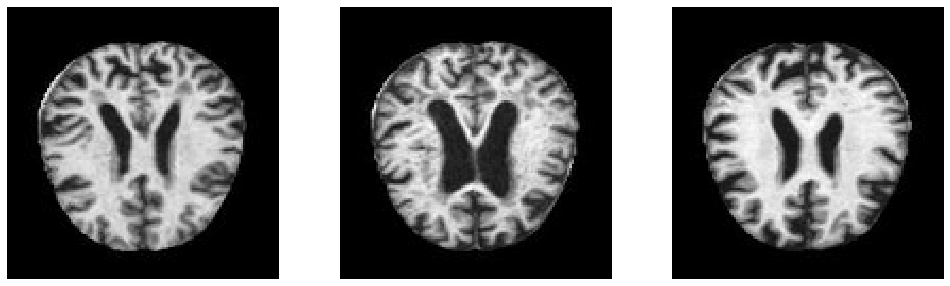

In [ ]:
MildDemented_dir= '/content/drive/MyDrive/alzheimer/Mild_Demented'
visualize(MildDemented_dir)

Moderate_Demented


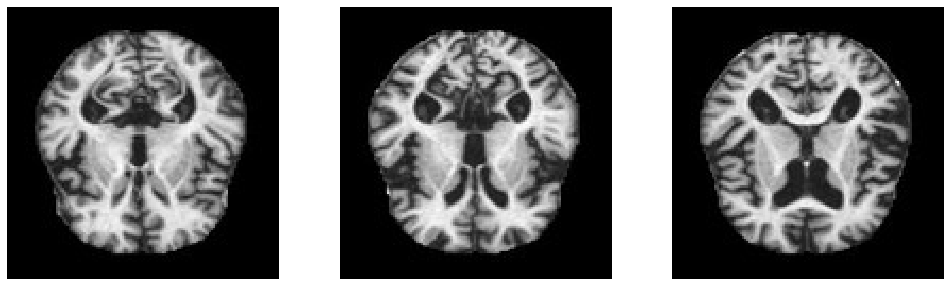

In [ ]:
ModerateDemented_dir= '/content/drive/MyDrive/alzheimer/Moderate_Demented'
visualize(ModerateDemented_dir)

Above we can see that the images in all classes are very similar. Only in the 'Moderate_Demented' class the brain changes are clearly visible. The poor quality of the photos may not make the final classification an easy task, but maybe that won't be a problem. 

In [ ]:
imageCount = len(list(IMG_DIR.glob("*/*.jpg") ))
imageCount

6400

<function matplotlib.pyplot.show>

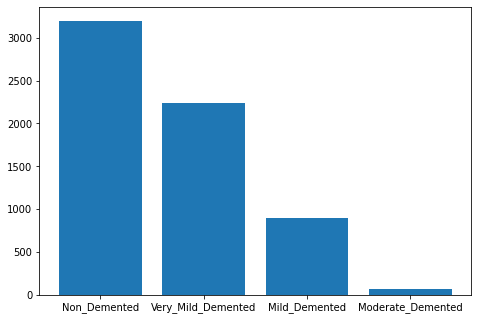

In [ ]:
class_names = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [3200,2240, 896,64]
ax.bar(class_names,size)
plt.show

The dataset consists of 6400 images. Unfortunately, their number is not equal for each class. 

# Loading dataset

I decided to divide datset into:


* training - 80%
* validation - 10%
* test - 10%



In [ ]:
splitfolders.ratio('/content/drive/MyDrive/alzheimer', output="output", seed=1345, ratio=(.8, 0.1,0.1)) 

Copying files: 6400 files [01:49, 58.21 files/s]


In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./output/train",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64
  )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./output/test",
    shuffle = False,
    label_mode='categorical',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./output/val",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64
  )

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Models

### Functions for plotting results

In [ ]:
import matplotlib.pyplot as plt
    
def PlotAccuracyComparison(acc, val_acc, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0)
    plt.figure(figsize=(25,5))
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) 
    plt.figure(figsize=(25,5))
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## First Model

This is my first, basic model. 

### Architecture

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               8388736   
                                                      

### Learning

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1)

Epoch 1/50
80/80 [==============================] - 3s 35ms/step - loss: 1.3390 - accuracy: 0.5241 - val_loss: 0.7795 - val_accuracy: 0.6385
Epoch 2/50
80/80 [==============================] - 3s 33ms/step - loss: 0.6461 - accuracy: 0.7402 - val_loss: 0.4802 - val_accuracy: 0.8513
Epoch 3/50
80/80 [==============================] - 3s 33ms/step - loss: 0.3381 - accuracy: 0.8883 - val_loss: 0.3220 - val_accuracy: 0.8701
Epoch 4/50
80/80 [==============================] - 3s 33ms/step - loss: 0.1744 - accuracy: 0.9562 - val_loss: 0.1463 - val_accuracy: 0.9624
Epoch 5/50
80/80 [==============================] - 3s 33ms/step - loss: 0.0820 - accuracy: 0.9828 - val_loss: 0.1034 - val_accuracy: 0.9781
Epoch 6/50
80/80 [==============================] - 3s 34ms/step - loss: 0.0577 - accuracy: 0.9885 - val_loss: 0.0788 - val_accuracy: 0.9797
Epoch 7/50
80/80 [==============================] - 3s 33ms/step - loss: 0.0471 - accuracy: 0.9873 - val_loss: 0.0643 - val_accuracy: 0.9844
Epoch 8/50
80

### Results

<Figure size 1800x720 with 0 Axes>

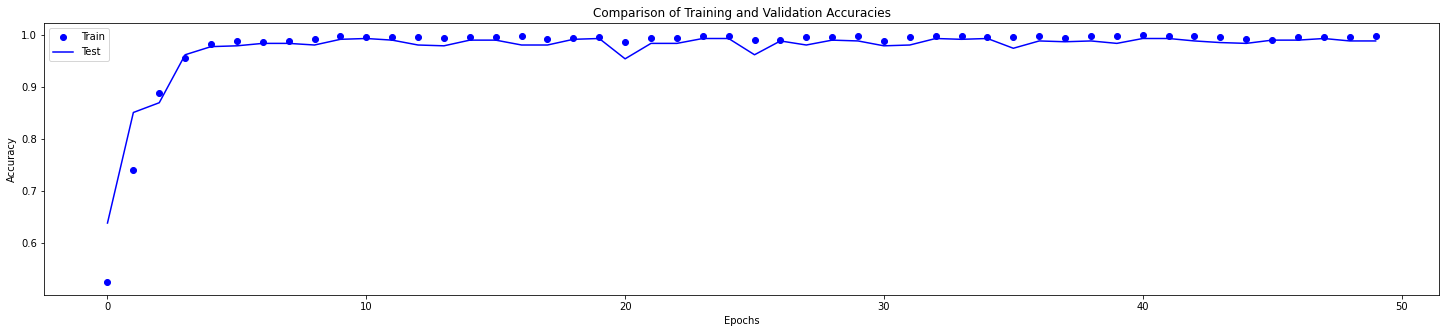

<Figure size 1800x720 with 0 Axes>

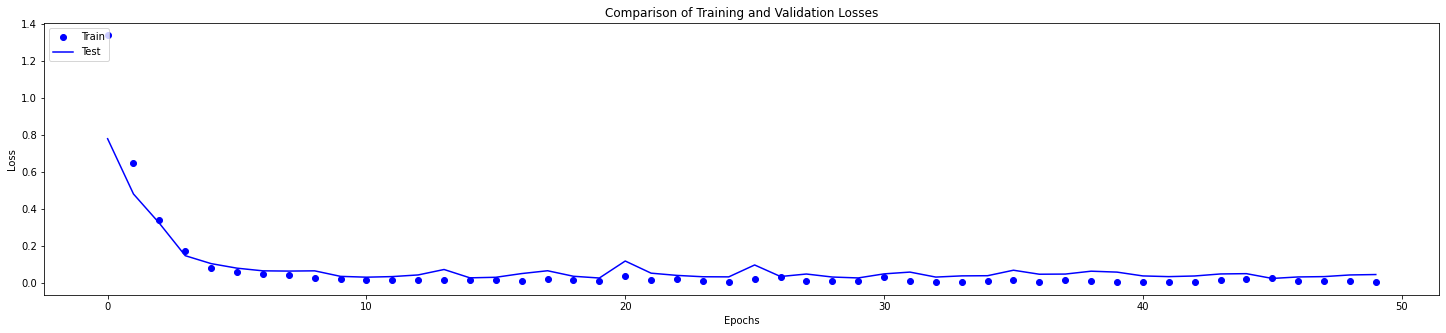

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model 1')

PlotLossComparison(loss, val_loss, lab = 'Model 1')

In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [ ]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        91
         1.0       1.00      1.00      1.00         7
         2.0       0.99      0.99      0.99       320
         3.0       0.97      1.00      0.98       224

    accuracy                           0.99       642
   macro avg       0.99      0.98      0.99       642
weighted avg       0.99      0.99      0.99       642



Confusion Matrix


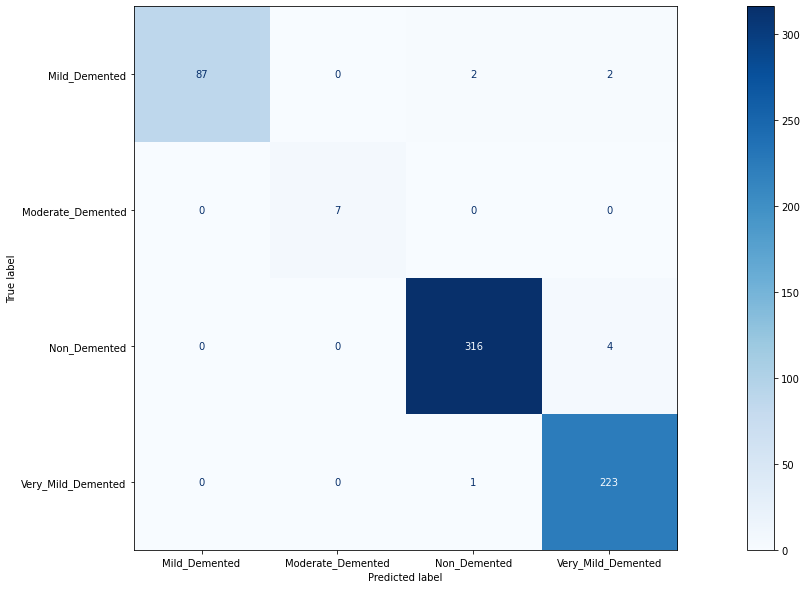

In [ ]:
print('Confusion Matrix')
plt.rcParams['figure.figsize'] = (25.0, 10.0)
cm = confusion_matrix(true_classes, prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Conclusion

The results are great, but I will try to improve them further.

## Second Model

I added some layers to the previous model (Model I).

### Architecture

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))

model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)       

### Learning

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1)

Epoch 1/50
80/80 [==============================] - 109s 1s/step - loss: 1.4248 - accuracy: 0.4769 - val_loss: 1.0705 - val_accuracy: 0.5509
Epoch 2/50
80/80 [==============================] - 114s 1s/step - loss: 0.9567 - accuracy: 0.5392 - val_loss: 0.8876 - val_accuracy: 0.6025
Epoch 3/50
80/80 [==============================] - 101s 1s/step - loss: 0.8749 - accuracy: 0.5845 - val_loss: 0.8708 - val_accuracy: 0.5556
Epoch 4/50
80/80 [==============================] - 102s 1s/step - loss: 0.8216 - accuracy: 0.6126 - val_loss: 0.7897 - val_accuracy: 0.6526
Epoch 5/50
80/80 [==============================] - 87s 1s/step - loss: 0.7441 - accuracy: 0.6646 - val_loss: 0.7020 - val_accuracy: 0.7058
Epoch 6/50
80/80 [==============================] - 89s 1s/step - loss: 0.6262 - accuracy: 0.7226 - val_loss: 0.5609 - val_accuracy: 0.7606
Epoch 7/50
80/80 [==============================] - 94s 1s/step - loss: 0.5692 - accuracy: 0.7531 - val_loss: 0.5286 - val_accuracy: 0.7793
Epoch 8/50
80/80

### Results

<Figure size 432x288 with 0 Axes>

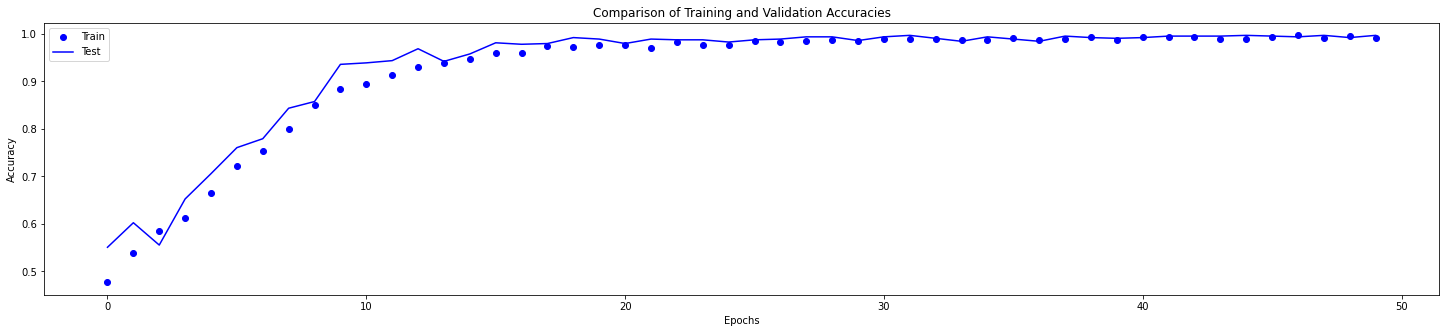

<Figure size 432x288 with 0 Axes>

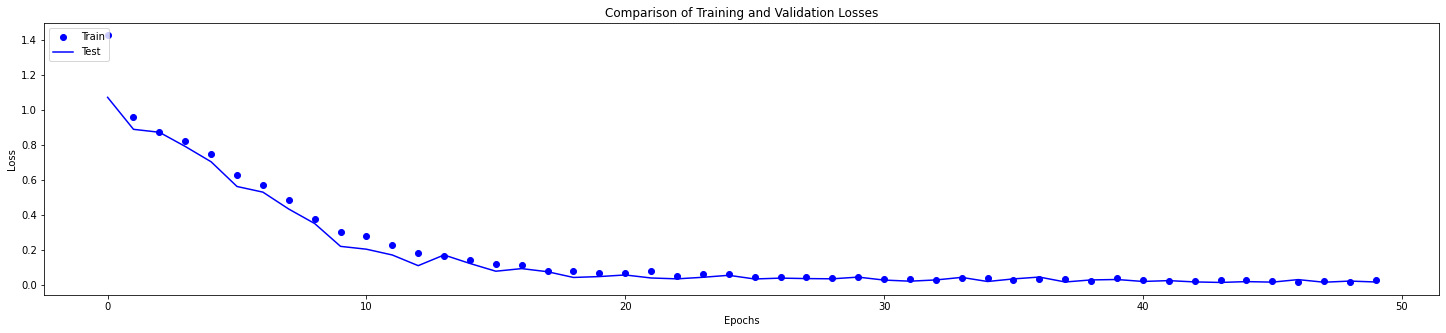

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model 1')

PlotLossComparison(loss, val_loss, lab = 'Model 1')

In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [ ]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        91
         1.0       1.00      1.00      1.00         7
         2.0       1.00      0.99      1.00       320
         3.0       0.99      1.00      0.99       224

    accuracy                           0.99       642
   macro avg       0.99      0.99      0.99       642
weighted avg       0.99      0.99      0.99       642



Confusion Matrix


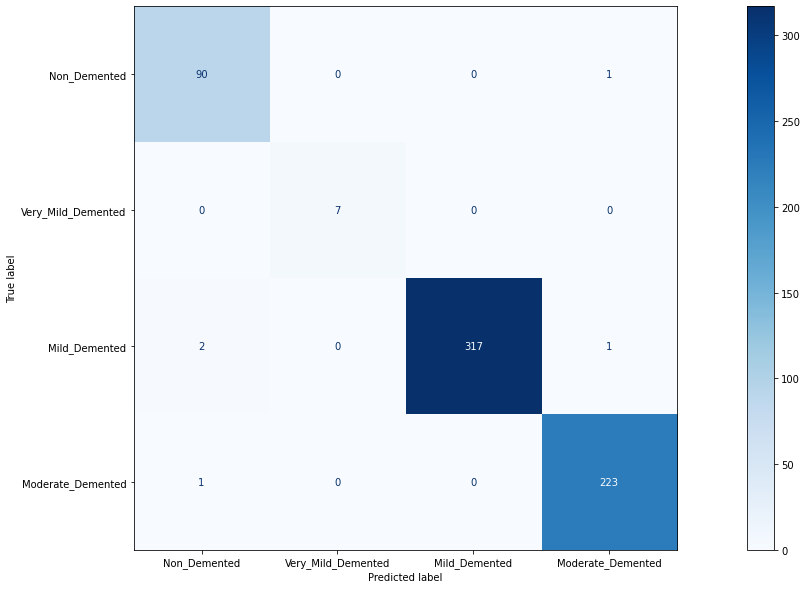

In [ ]:
print('Confusion Matrix')
plt.rcParams['figure.figsize'] = (25.0, 10.0)
cm = confusion_matrix(true_classes, prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Conclusion

The results are similar, but loss and accuracy graphs are a little worse. The training process ongoing a little longer, because model is more complicated.

## Third Model 

I decided to add more layers to the model and check the results.

### Architecture

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0

### Learning

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1)

Epoch 1/50
80/80 [==============================] - 16s 41ms/step - loss: 1.1482 - accuracy: 0.4743 - val_loss: 1.0909 - val_accuracy: 0.5008
Epoch 2/50
80/80 [==============================] - 3s 36ms/step - loss: 1.0267 - accuracy: 0.4983 - val_loss: 1.0605 - val_accuracy: 0.5039
Epoch 3/50
80/80 [==============================] - 3s 34ms/step - loss: 0.9889 - accuracy: 0.5249 - val_loss: 0.9575 - val_accuracy: 0.5321
Epoch 4/50
80/80 [==============================] - 3s 34ms/step - loss: 0.9524 - accuracy: 0.5429 - val_loss: 0.8786 - val_accuracy: 0.6291
Epoch 5/50
80/80 [==============================] - 3s 36ms/step - loss: 0.9006 - accuracy: 0.5753 - val_loss: 0.8784 - val_accuracy: 0.5915
Epoch 6/50
80/80 [==============================] - 4s 42ms/step - loss: 0.8868 - accuracy: 0.5857 - val_loss: 0.8587 - val_accuracy: 0.6401
Epoch 7/50
80/80 [==============================] - 3s 35ms/step - loss: 0.8683 - accuracy: 0.6001 - val_loss: 0.8127 - val_accuracy: 0.6291
Epoch 8/50
8

### Results

<Figure size 432x288 with 0 Axes>

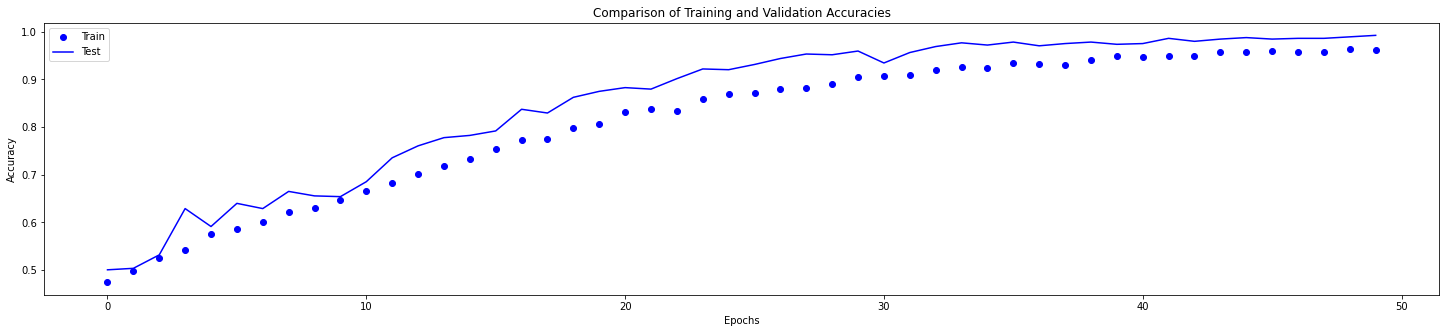

<Figure size 432x288 with 0 Axes>

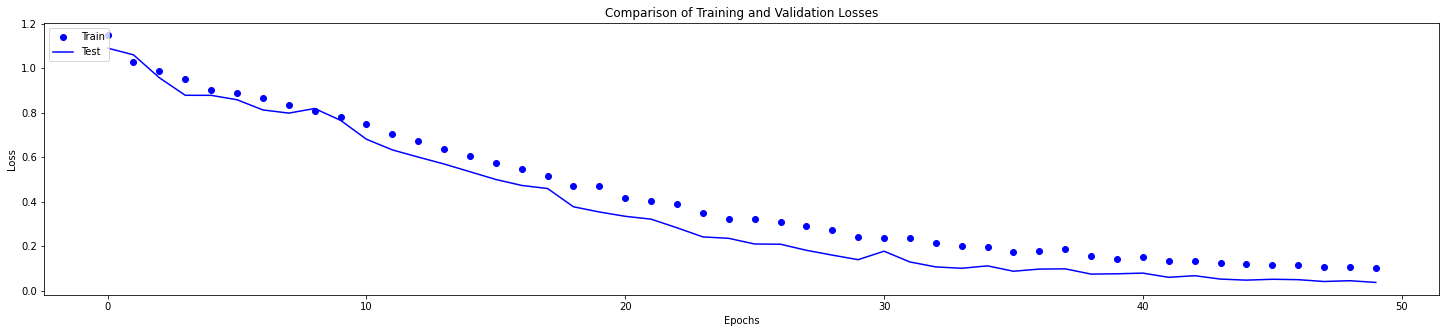

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model 2')

PlotLossComparison(loss, val_loss, lab = 'Model 2')

In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [ ]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        91
         1.0       1.00      1.00      1.00         7
         2.0       0.99      1.00      0.99       320
         3.0       0.99      0.99      0.99       224

    accuracy                           0.99       642
   macro avg       0.99      0.99      0.99       642
weighted avg       0.99      0.99      0.99       642



Confusion Matrix


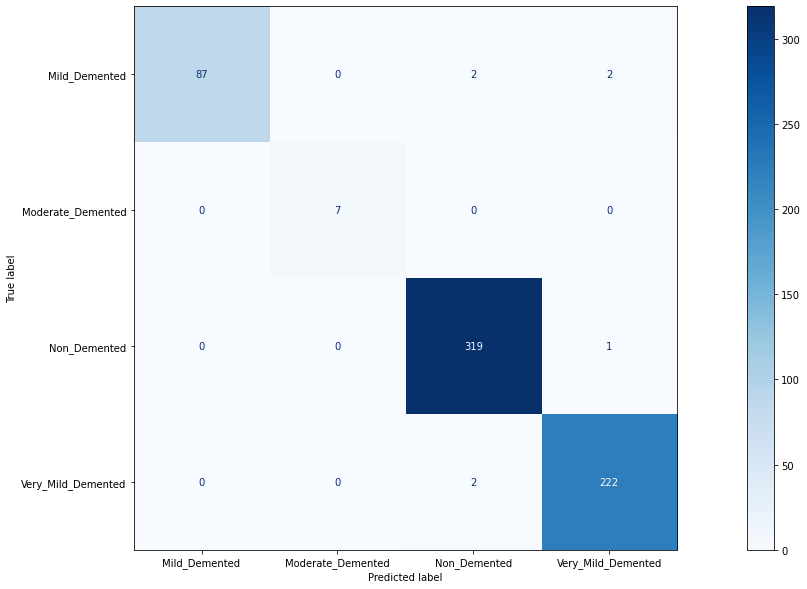

In [ ]:
print('Confusion Matrix')
plt.rcParams['figure.figsize'] = (25.0, 10.0)
cm = confusion_matrix(true_classes, prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Conclusion

The results are similar to the previous ones but the process takes much longer. 

## Fourth model

I decided to try transfer leaning. I used VGG model.

### Architecture

In [ ]:
from keras.applications.vgg16 import VGG16

model_VGG16 = VGG16(include_top=False,
                    weights='imagenet',
                    input_shape=(128, 128, 3))

In [ ]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
model = models.Sequential()
model.add(model_VGG16)
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout_7 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 4)                 32772     
                                                                 
Total params: 14,747,460
Trainable params: 14,747,460
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

### Learning

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1)

Epoch 1/50
80/80 [==============================] - 24s 284ms/step - loss: 6.2773 - accuracy: 0.4565 - val_loss: 1.0232 - val_accuracy: 0.5196
Epoch 2/50
80/80 [==============================] - 23s 285ms/step - loss: 1.0254 - accuracy: 0.5114 - val_loss: 0.9648 - val_accuracy: 0.5822
Epoch 3/50
80/80 [==============================] - 23s 290ms/step - loss: 0.9900 - accuracy: 0.5198 - val_loss: 1.8955 - val_accuracy: 0.5008
Epoch 4/50
80/80 [==============================] - 24s 292ms/step - loss: 0.9947 - accuracy: 0.5247 - val_loss: 0.9212 - val_accuracy: 0.6041
Epoch 5/50
80/80 [==============================] - 24s 295ms/step - loss: 0.9445 - accuracy: 0.5495 - val_loss: 0.9344 - val_accuracy: 0.5915
Epoch 6/50
80/80 [==============================] - 24s 295ms/step - loss: 0.9247 - accuracy: 0.5599 - val_loss: 0.8795 - val_accuracy: 0.5696
Epoch 7/50
80/80 [==============================] - 24s 296ms/step - loss: 0.8986 - accuracy: 0.5773 - val_loss: 0.8270 - val_accuracy: 0.6182

### Results

<Figure size 1800x720 with 0 Axes>

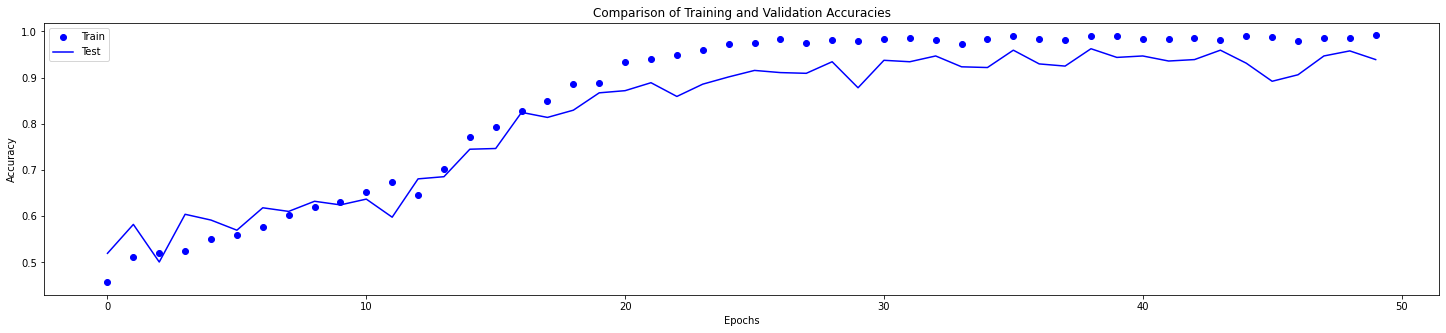

<Figure size 1800x720 with 0 Axes>

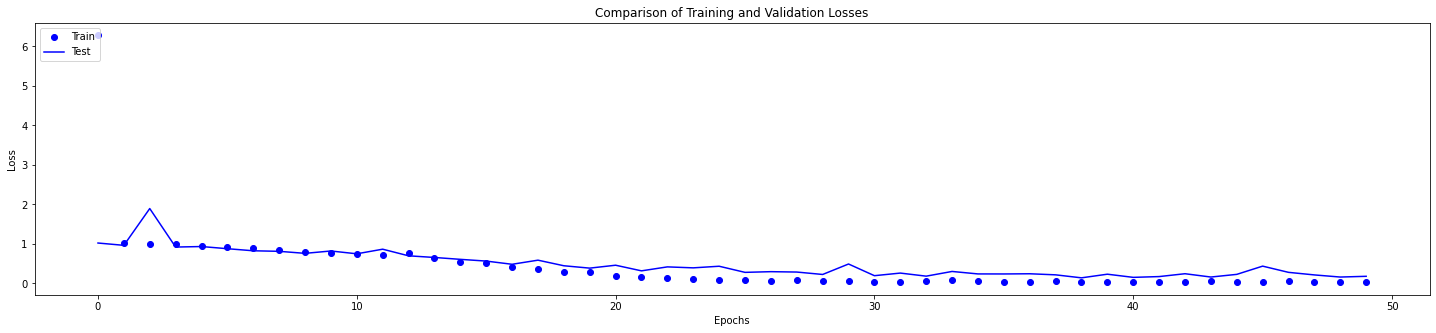

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model 1')

PlotLossComparison(loss, val_loss, lab = 'Model 1')

In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [ ]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92        91
         1.0       1.00      0.43      0.60         7
         2.0       0.98      0.93      0.95       320
         3.0       0.90      0.95      0.92       224

    accuracy                           0.93       642
   macro avg       0.94      0.82      0.85       642
weighted avg       0.94      0.93      0.93       642



Confusion Matrix


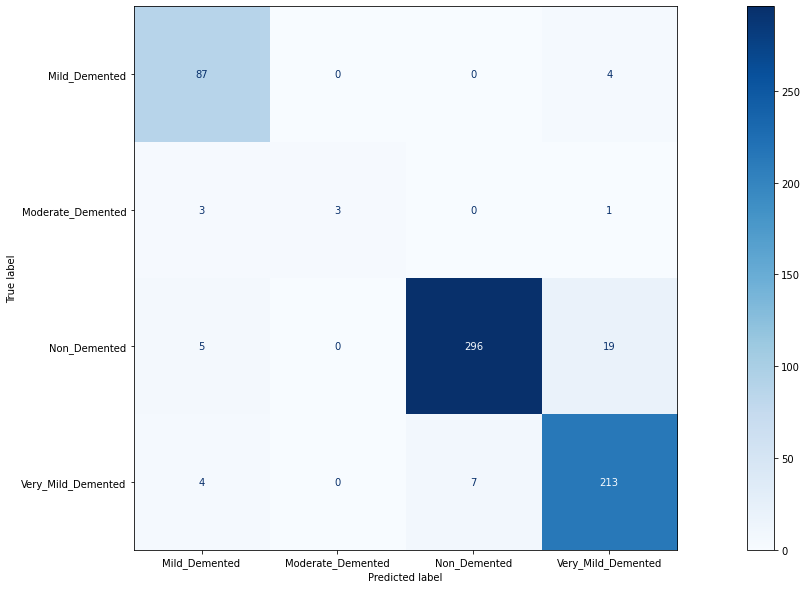

In [ ]:
print('Confusion Matrix')
plt.rcParams['figure.figsize'] = (25.0, 10.0)
cm = confusion_matrix(true_classes, prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Conclusion

The learning process looks good, but the results are weaker (only 93%).

## Fifth model

I decided to add more layers to VGG16 model.

### Architecture

In [ ]:
from keras.applications.vgg16 import VGG16

model_VGG16 = VGG16(include_top=False,
                    weights='imagenet',
                    input_shape=(128, 128, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
model = models.Sequential()
model.add(model_VGG16)
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         589952    
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 128)        512       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 128)              

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

### Learning

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1)

Epoch 1/50
80/80 [==============================] - 46s 496ms/step - loss: 1.0394 - accuracy: 0.4954 - val_loss: 7.0788 - val_accuracy: 0.5008
Epoch 2/50
80/80 [==============================] - 24s 299ms/step - loss: 0.9339 - accuracy: 0.5255 - val_loss: 1.9590 - val_accuracy: 0.1393
Epoch 3/50
80/80 [==============================] - 24s 300ms/step - loss: 0.8931 - accuracy: 0.5655 - val_loss: 1.6188 - val_accuracy: 0.1393
Epoch 4/50
80/80 [==============================] - 25s 303ms/step - loss: 0.8921 - accuracy: 0.5751 - val_loss: 1.1329 - val_accuracy: 0.3255
Epoch 5/50
80/80 [==============================] - 24s 299ms/step - loss: 0.8659 - accuracy: 0.5810 - val_loss: 2.4789 - val_accuracy: 0.1393
Epoch 6/50
80/80 [==============================] - 25s 305ms/step - loss: 0.8459 - accuracy: 0.5851 - val_loss: 2.2502 - val_accuracy: 0.1393
Epoch 7/50
80/80 [==============================] - 25s 305ms/step - loss: 0.8209 - accuracy: 0.5997 - val_loss: 0.8364 - val_accuracy: 0.6056

### Results

<Figure size 1800x720 with 0 Axes>

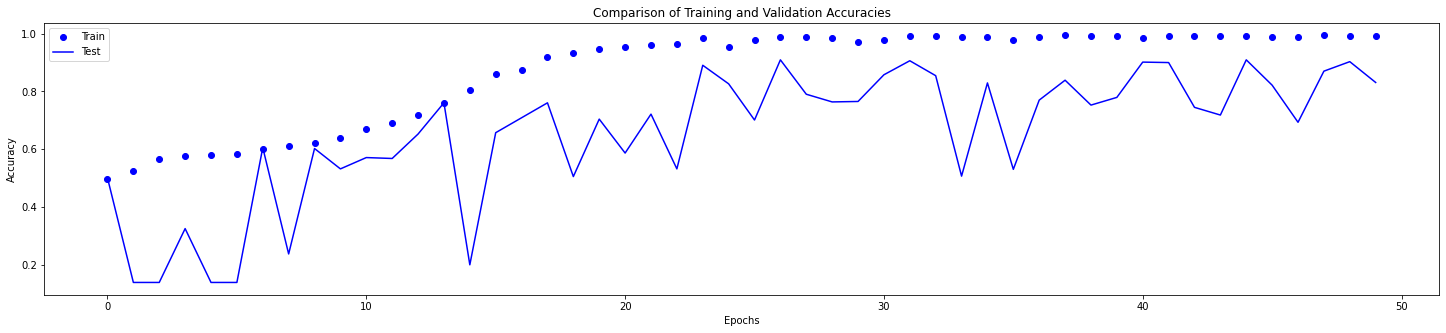

<Figure size 1800x720 with 0 Axes>

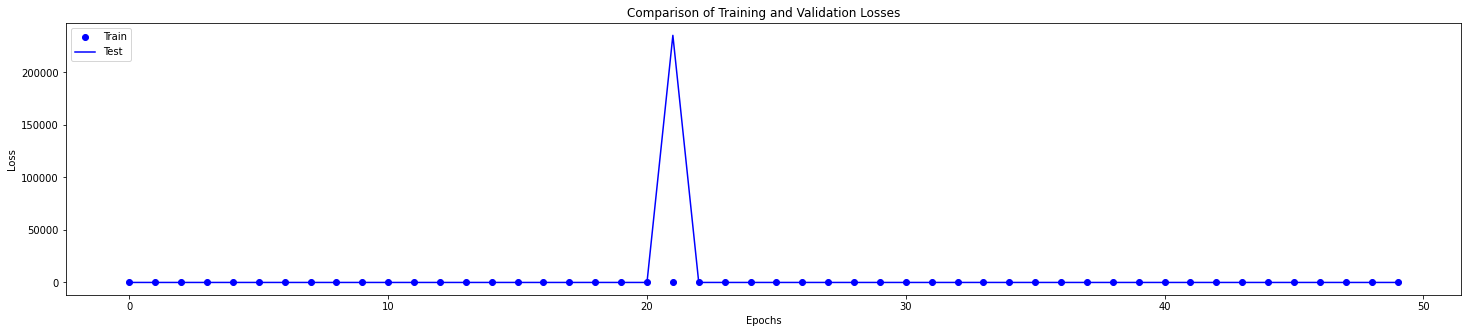

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotAccuracyComparison(acc, val_acc, lab = 'Model 1')

PlotLossComparison(loss, val_loss, lab = 'Model 1')

In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [ ]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85        91
         1.0       0.67      0.86      0.75         7
         2.0       0.81      0.98      0.89       320
         3.0       0.88      0.69      0.77       224

    accuracy                           0.85       642
   macro avg       0.83      0.82      0.82       642
weighted avg       0.86      0.85      0.84       642



Confusion Matrix


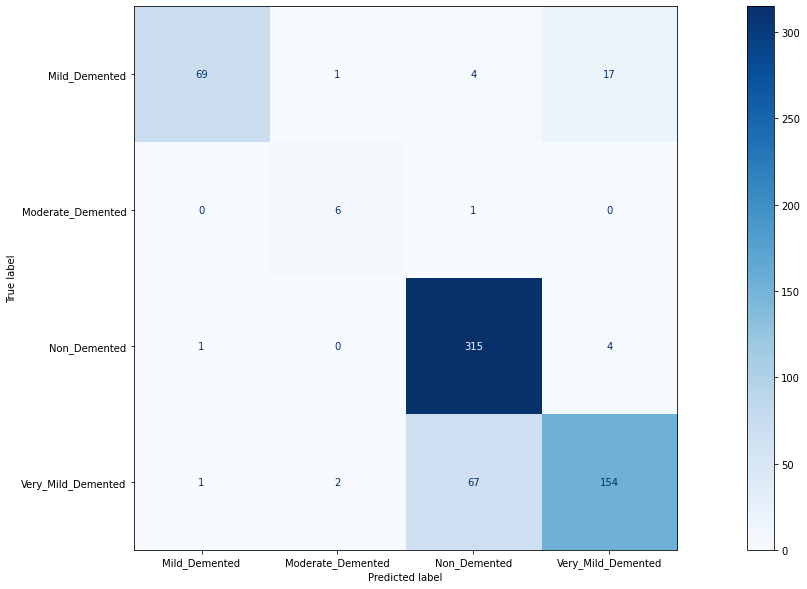

In [ ]:
print('Confusion Matrix')
plt.rcParams['figure.figsize'] = (25.0, 10.0)
cm = confusion_matrix(true_classes, prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Conclusion

Results are much worse, accuracy is only 85%. The graphs do not look good either. It looks like the model is too complicated 


## Sixth Model

Finally, I decided to test a completely different approach - logistic regression. 

### Loading data

I decided to divide datset into:

* training - 80%
* test - 10%



In [ ]:
splitfolders.ratio('/content/drive/MyDrive/alzheimer', output="output", seed=1345, ratio=(.8, 0.2)) 

Copying files: 6400 files [00:12, 518.13 files/s]


In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./output/train",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH)
  )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./output/test",
    shuffle = False,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH))

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
X_train = np.concatenate([x for x, y in train_ds], axis=0)
X_test = np.concatenate([x for x, y in test_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

In [ ]:
image_shape = (128, 128)
X_train = []
X_test = []
for img in X_train_scaled:
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(gray, image_shape)
  X_train.append(img)

for img in X_test_scaled:
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(gray, image_shape)
  X_test.append(img)

In [ ]:
train_features = []
for img in X_train:
  train_features.append(np.reshape(img, (128*128)))

test_features = []
for img in X_test:
  test_features.append(np.reshape(img, (128*128)))

### Learning

In [ ]:
clf = LogisticRegression(penalty='l1', tol=0.01, solver='saga', multi_class='multinomial').fit(train_features, y_train)
#to check the shape of the coefficient matrix
clf.coef_.shape

(4, 16384)

### Results

One benefit of logistic regression is its interpretability. We can use the coefficient values to understand what features (i.e. which pixels) are important in determining what class a sample belongs to.The following plot shows the coefficient vector for each class, with positive coefficients in blue and negative coefficients in red.

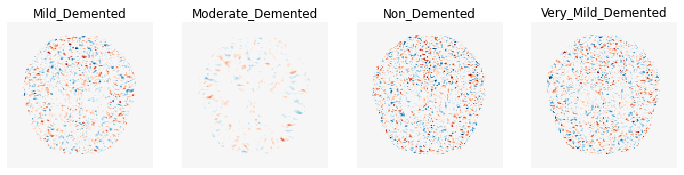

In [ ]:
scale = np.max(np.abs(clf.coef_))
p = plt.figure(figsize=(12, 10));
nclasses = 4
for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(128, 128),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title(class_names[i])

<function matplotlib.pyplot.show>

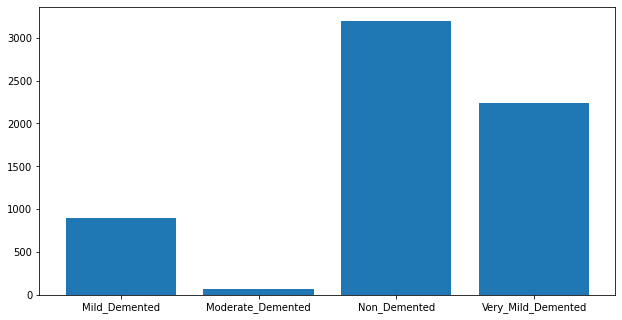

In [ ]:
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


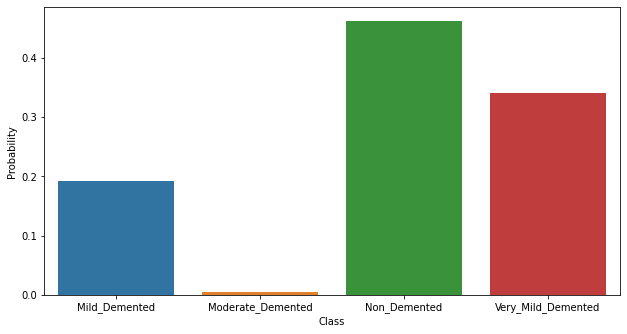

In [ ]:
sample_idx = 5
z = [ clf.intercept_[k] + np.dot(clf.coef_[k], test[sample_idx]) for k in range(4) ]
#conditional probability
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
exps = [np.exp(z[k]) for k in range(4)]
exps_sum = np.sum(exps)
probs = exps/exps_sum
probs
#plot
sns.barplot(['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'], probs);
plt.ylabel("Probability");
plt.xlabel("Class");

This graph shows the probability of each class occurring. We can see that the distribution is similar to the class counts. In general, to get the predicted label, we can find the class with the highest probability. If this matches the actual label for the first test sample, then our prediction is correct.

In [ ]:
class_names = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

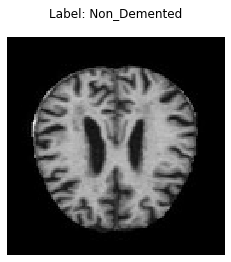

In [ ]:
#sample number
sample_idx = 5
#plotting image
plt.imshow(test_features[sample_idx].reshape(128,128), cmap='gray');
plt.title('Label: %s\n' % class_names[y_test[sample_idx]]);
plt.axis('off');

In [ ]:
y_pred = clf.predict(test_features)

In [ ]:
accuracy =  np.mean(y_test == y_pred)
print(accuracy)

0.4485981308411215


In [ ]:
y_pred_encoded = list()
for i in y_pred:
  y_pred_encoded.append(class_names[i])

y_test_encoded = list()
for i in y_test:
  y_test_encoded.append(class_names[i])

y_test_encoded = np.array(y_test_encoded)
y_pred_encoded = np.array(y_pred_encoded)

print('Classification Report')
print(classification_report(y_test_encoded, y_pred_encoded))

Classification Report
                    precision    recall  f1-score   support

     Mild_Demented       0.51      0.68      0.58       320
 Moderate_Demented       0.37      0.31      0.34       224
      Non_Demented       0.04      0.01      0.02        91
Very_Mild_Demented       0.00      0.00      0.00         7

          accuracy                           0.45       642
         macro avg       0.23      0.25      0.23       642
      weighted avg       0.39      0.45      0.41       642



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix


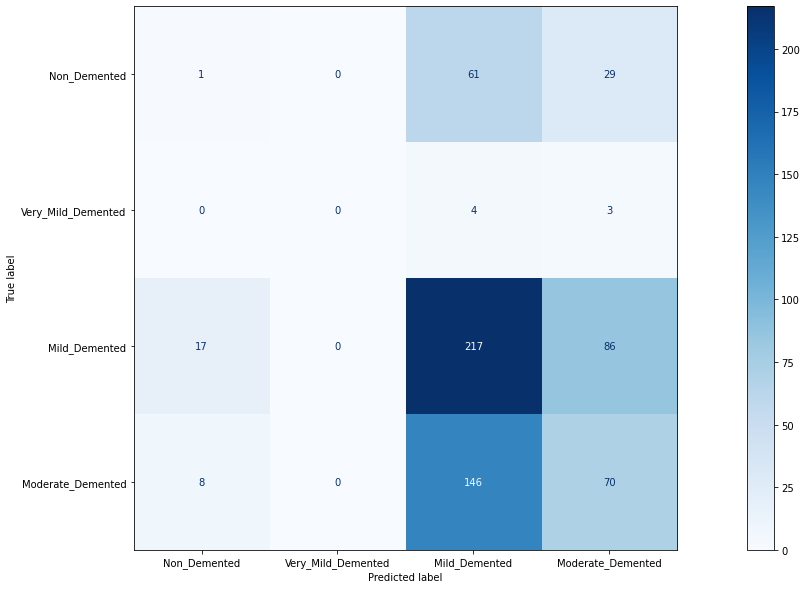

In [ ]:
print('Confusion Matrix')
plt.rcParams['figure.figsize'] = (25.0, 10.0)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Conclusion

Accuracy is equal only to 45%. Logistic regression has not worked well in this project.


## Seventh Model

This is also logistic regression model, but with different parameters.

### Learning

In [ ]:
clf = LogisticRegression(penalty='l2', tol=0.001, solver= 'lbfgs', multi_class='auto').fit(train_features, y_train)
#to check the shape of the coefficient matrix
clf.coef_.shape

### Results

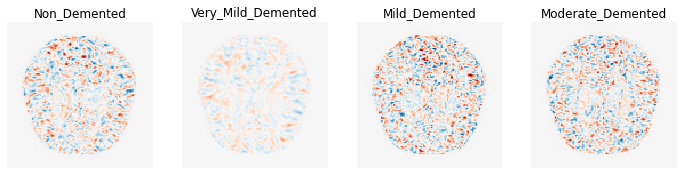

In [ ]:
scale = np.max(np.abs(clf.coef_))
p = plt.figure(figsize=(12, 10));
nclasses = 4
for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(128, 128),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title(class_names[i])

<function matplotlib.pyplot.show>

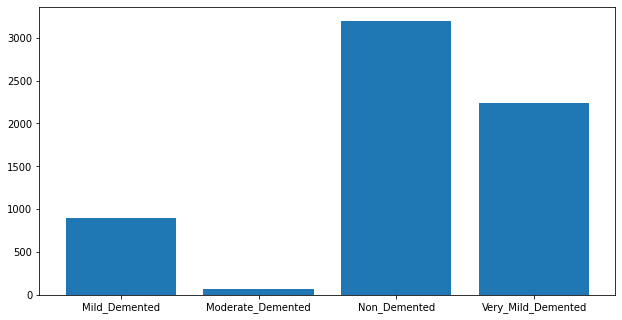

In [ ]:
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


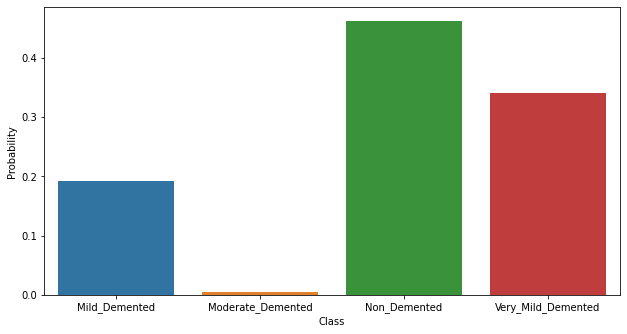

In [ ]:
sample_idx = 5
z = [ clf.intercept_[k] + np.dot(clf.coef_[k], test[sample_idx]) for k in range(4) ]
#conditional probability
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
exps = [np.exp(z[k]) for k in range(4)]
exps_sum = np.sum(exps)
probs = exps/exps_sum
probs
#plot
sns.barplot(['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'], probs);
plt.ylabel("Probability");
plt.xlabel("Class");

This graph shows the probability of each class occurring. We can see that the distribution is similar to the class counts. In general, to get the predicted label, we can find the class with the highest probability. If this matches the actual label for the first test sample, then our prediction is correct.

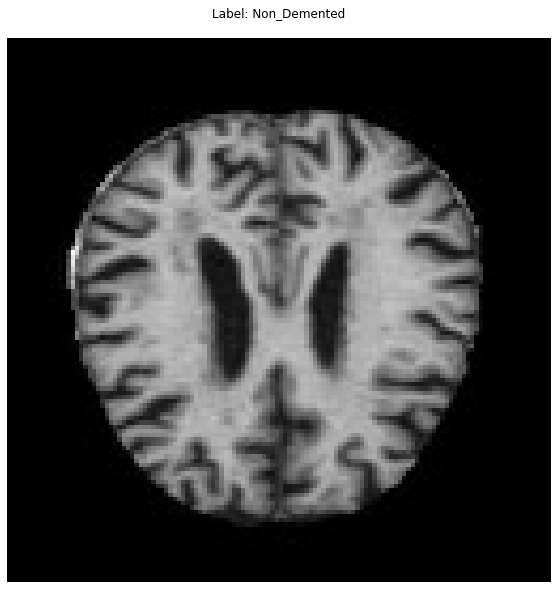

In [ ]:
#sample number
sample_idx = 5
#plotting image
plt.imshow(test_features[sample_idx].reshape(128,128), cmap='gray');
plt.title('Label: %s\n' % class_names[y_test[sample_idx]]);
plt.axis('off');

In [ ]:
y_pred = clf.predict(test_features)

In [ ]:
accuracy =  np.mean(y_test == y_pred)
print(accuracy)

0.4454828660436137


In [ ]:
y_pred_encoded = list()
for i in y_pred:
  y_pred_encoded.append(class_names[i])

y_test_encoded = list()
for i in y_test:
  y_test_encoded.append(class_names[i])

y_test_encoded = np.array(y_test_encoded)
y_pred_encoded = np.array(y_pred_encoded)

print('Classification Report')
print(classification_report(y_test_encoded, y_pred_encoded))

Classification Report
                    precision    recall  f1-score   support

     Mild_Demented       0.52      0.64      0.58       320
 Moderate_Demented       0.38      0.32      0.35       224
      Non_Demented       0.15      0.09      0.11        91
Very_Mild_Demented       0.00      0.00      0.00         7

          accuracy                           0.45       642
         macro avg       0.26      0.26      0.26       642
      weighted avg       0.41      0.45      0.42       642



Confusion Matrix


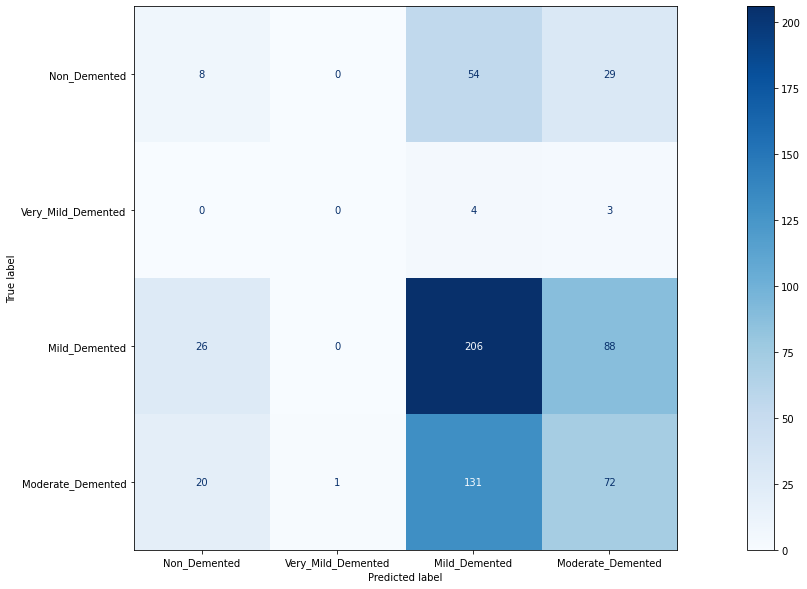

In [ ]:
print('Confusion Matrix')
plt.rcParams['figure.figsize'] = (25.0, 10.0)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Conclusion

Situation similar to the previous model. Despite changing parameters the results are very poor. 